<a href="https://colab.research.google.com/github/adwaitgondhalekar/Image-Colour-HIstogram-Matching/blob/main/Image_Colour_Histogram_Matching.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
from __future__ import print_function

# Indispensables packages for neural networks with Pytorch
import torch
import torch.nn as nn                            # a neural networks library deeply integrated with autograd designed
                                                 # for maximum flexibility.
import torch.nn.functional as F                  #Convolution functions
import torch.optim as optim                      # efficient gradient descents

#Load and Display images
from PIL import Image
import matplotlib.pyplot as plt                  #Pyplot is a Matplotlib module which provides a MATLAB-like interface.
                                                 #Each pyplot function makes some change to a figure: e.g., creates a figure, creates a plotting area in a figure,
                                                 #plots some lines in a plotting area, decorates the plot with labels, etc.

import torchvision.transforms as transforms      # Transform PIL images into tensors
import torchvision.models as models              # we will load the pre-trained VGG19 model from the torchvision.models().
from torchvision.utils import save_image

import copy                                      # To deep copy the models; system package 

import tensorflow as tf
from tensorflow.python.client import device_lib
import cv2 # Import the OpenCV library
import numpy as np

In [14]:
#CUDA allows developers to accelerate computational-intensive applications by exploiting the power of GPUs for the parallel part of the computation.

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  #To detect if there is a GPU available
print(device,"is detected")


cuda is detected


In [15]:
tf.test.gpu_device_name()
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 15018152939198879616
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 13266321408
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 11410318837476775777
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
 xla_global_id: 416903419]

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
def calculate_pdf(dict1):
    pdf=dict()

    for x,y in dict1.items():
      pdf[x] = y/(512 * 512)

    return pdf


def calculate_cdf(pdf_dict):
    cdf = dict()
    prev = 0
    for x,y in pdf_dict.items():
      cdf[x] =  prev +  pdf_dict[x]
      prev = cdf[x]

    return cdf


def equalize(cdf_dict, max_gray_level):
    equalized_pixels=dict()

    for x,y in cdf_dict.items():
      equalized_pixels[x] = int(np.round((cdf_dict[x] * max_gray_level)))

    return equalized_pixels

def get_matched_pixels(image1_equalized, image2_equalized):

  for x,y in image1_equalized.items():
    level = y
    min = 1000
    for a,b in image2_equalized.items():
      difference = b - level
      flag=0
      if difference==0:
        new_level = a
        image1_equalized[x] = new_level
        flag=1
        break
      else:
        if (difference < min) and (difference>0) :
          min = difference
          next_new_level = a
    if flag==0:
      image1_equalized[x] = next_new_level


  return image1_equalized   


def get_pixel_count(image_pixel_dict, img_max_grayscale, image):

  for gray_scale in range(0,img_max_grayscale + 1):
      image_pixel_dict[gray_scale] = image.tolist().count(gray_scale)

  return image_pixel_dict


def transform_image(R_pixels, G_pixels, B_pixels, R_mapping, G_mapping, B_mapping):
  
  for i in range(0,len(R_pixels)):

     new_pixel = R_mapping.get(R_pixels[i])
     R_pixels[i] = new_pixel

     new_pixel = G_mapping.get(G_pixels[i])
     G_pixels[i] = new_pixel

     new_pixel = B_mapping.get(B_pixels[i])
     B_pixels[i] = new_pixel


  r = Image.fromarray((R_pixels.reshape(512,512).astype(np.uint8)))
  g = Image.fromarray((G_pixels.reshape(512,512).astype(np.uint8)))
  b = Image.fromarray((B_pixels.reshape(512,512).astype(np.uint8)))

  merged = Image.merge(mode="RGB",bands = (r,g,b))
  return merged


def histogram_equalization(image1, image2):

    image1_R, image1_G, image1_B = image1.split()                                                 #Split Image into R, G, B channels

    image2_R, image2_G, image2_B = image2.split()                                                 #Split Image into R, G, B channels

    img1_R_max_pixel = np.amax(np.array(image1_R, dtype=int))                                     #Get max pixel value
    img1_G_max_pixel = np.amax(np.array(image1_G, dtype=int))
    img1_B_max_pixel = np.amax(np.array(image1_B, dtype=int))

    img2_R_max_pixel = np.amax(np.array(image2_R, dtype=int))                                     #Get max pixel value
    img2_G_max_pixel = np.amax(np.array(image2_G, dtype=int))
    img2_B_max_pixel = np.amax(np.array(image2_B, dtype=int))

    image1_R_flat = np.array(image1_R, dtype=int).flatten()                                       #Flatten individual channel of images
    image1_G_flat = np.array(image1_G, dtype=int).flatten()
    image1_B_flat = np.array(image1_B, dtype=int).flatten()
  
    image2_R_flat = np.array(image2_R, dtype=int).flatten()                                       #Flatten individual channel of images
    image2_G_flat = np.array(image2_G, dtype=int).flatten()
    image2_B_flat = np.array(image2_B, dtype=int).flatten()

    img1_R_max_gray_level = int(np.power(2,np.ceil(np.log2(img1_R_max_pixel)))) - 1               #Calculate max grayscale level
    img1_G_max_gray_level = int(np.power(2,np.ceil(np.log2(img1_G_max_pixel)))) - 1
    img1_B_max_gray_level = int(np.power(2,np.ceil(np.log2(img1_B_max_pixel)))) - 1

    
    img2_R_max_gray_level = int(np.power(2,np.ceil(np.log2(img2_R_max_pixel)))) - 1               #Calculate max grayscale level
    img2_G_max_gray_level = int(np.power(2,np.ceil(np.log2(img2_G_max_pixel)))) - 1
    img2_B_max_gray_level = int(np.power(2,np.ceil(np.log2(img2_B_max_pixel)))) - 1

    img1_R_pixels = dict()
    img1_G_pixels = dict()
    img1_B_pixels = dict()

    img2_R_pixels = dict()
    img2_G_pixels = dict()
    img2_B_pixels = dict()


    img1_R_pixels = get_pixel_count(img1_R_pixels, img1_R_max_gray_level, image1_R_flat)          #Get pixel count for each grayscale level
    img1_G_pixels = get_pixel_count(img1_G_pixels, img1_G_max_gray_level, image1_G_flat)
    img1_B_pixels = get_pixel_count(img1_B_pixels, img1_B_max_gray_level, image1_B_flat)

    img2_R_pixels = get_pixel_count(img2_R_pixels, img2_R_max_gray_level, image2_R_flat)          #Get pixel count for each grayscale level
    img2_G_pixels = get_pixel_count(img2_G_pixels, img2_G_max_gray_level, image2_G_flat)
    img2_B_pixels = get_pixel_count(img2_B_pixels, img2_B_max_gray_level, image2_B_flat)

    
    img1_R_pdf = calculate_pdf(img1_R_pixels)                                                     #Calculate pdf
    img1_G_pdf = calculate_pdf(img1_G_pixels)
    img1_B_pdf = calculate_pdf(img1_B_pixels)

    img2_R_pdf = calculate_pdf(img2_R_pixels)                                                     #Calculate pdf
    img2_G_pdf = calculate_pdf(img2_G_pixels)
    img2_B_pdf = calculate_pdf(img2_B_pixels)

    img1_R_cdf = calculate_cdf(img1_R_pdf)                                                        #Calculate cdf
    img1_G_cdf = calculate_cdf(img1_G_pdf)  
    img1_B_cdf = calculate_cdf(img1_B_pdf)

    img2_R_cdf = calculate_cdf(img2_R_pdf)                                                        #Calculate cdf
    img2_G_cdf = calculate_cdf(img2_G_pdf)
    img2_B_cdf = calculate_cdf(img2_B_pdf)

    img1_R_equalized = equalize(img1_R_cdf, img1_R_max_gray_level)                                #Histogram Equalization of Image 1
    img1_G_equalized = equalize(img1_G_cdf, img1_G_max_gray_level)
    img1_B_equalized = equalize(img1_B_cdf, img1_B_max_gray_level)

    img2_R_equalized = equalize(img2_R_cdf, img2_R_max_gray_level)                                #Histogram Equalization of Image 2
    img2_G_equalized = equalize(img2_G_cdf, img2_G_max_gray_level)
    img2_B_equalized = equalize(img2_B_cdf, img2_B_max_gray_level)


    img1_R_matched = get_matched_pixels(img1_R_equalized, img2_R_equalized)                       #Matching Histogram of Image 1 to Image 2
    img1_G_matched = get_matched_pixels(img1_G_equalized, img2_G_equalized)
    img1_B_matched = get_matched_pixels(img1_B_equalized, img2_B_equalized)

    #new_image1 = transform_image(image1_R_flat, image1_G_flat, image1_B_flat, img1_R_matched, img1_G_matched, img1_B_matched)

    new_image1 = transform_image(image1_R_flat, image1_G_flat, image1_B_flat, img1_R_matched, img1_G_matched, img1_B_matched)
    new_image2 = transform_image(image1_R_flat, image1_G_flat, image1_B_flat, img1_R_equalized, img1_G_equalized, img1_B_equalized)
    new_image3 = transform_image(image2_R_flat, image2_G_flat, image2_B_flat, img2_R_equalized, img2_G_equalized, img2_B_equalized)

    #return new_image1

    return new_image1, new_image2, new_image3

    

    
  


Text(0.5, 1.0, 'Histogram Equalized Content Image')

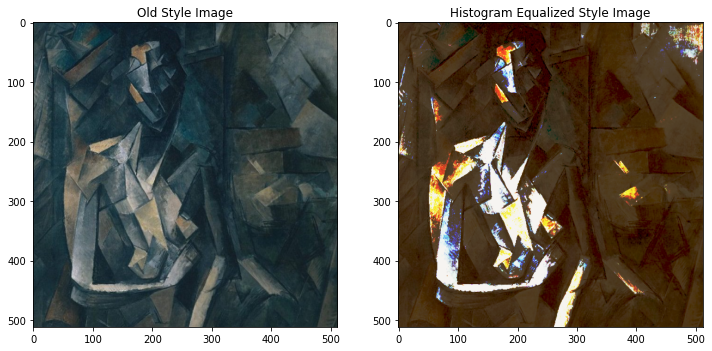

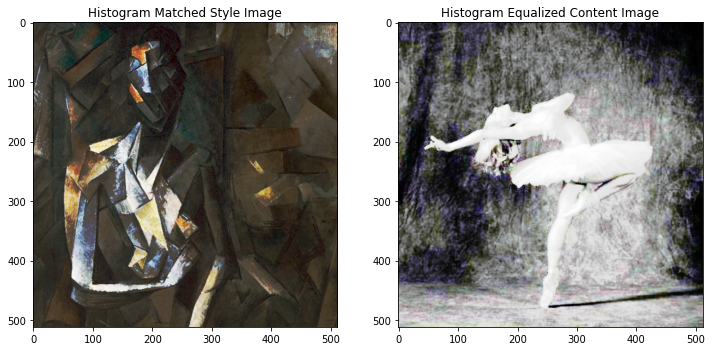

In [19]:
image_size = 512 if torch.cuda.is_available() else 128 

Image_Transform = transforms.Compose(
    [transforms.Resize(image_size),                     # scale imported image
    transforms.ToTensor()])                             # here we transform it into a torch tensor


Image_Transform_resize = transforms.Compose(
    [transforms.Resize(image_size)])


# Image Loader Function (Load Image and Returns cuda tensor)
def ImageLoader(image_name):   
  
  image = Image.open(image_name)               
  # Open the image and store in a variable.
  
  image_mode = image.mode
  image = Image_Transform_resize(image)  
  #Calling Image_Transform with our image.
  #unsqueeze(0) is used to add extra layer of dimensionality to the image. 
  #fake batch dimension required to fit network's input dimensions.                                              
  
  return image                  
  #Returning image   
  # .to Method is used to move tensors or modules to a desired device.


image_location = "/content/drive/MyDrive/BE_PROJECT_IMAGES/"
content_image = ImageLoader(image_location + "content_images/dancing.jpg") 
style_image = ImageLoader(image_location + "style_images/picasso.jpg")

row = 1
col = 2

  

fig = plt.figure(figsize=(12, 6))
fig.add_subplot(row, col, 1)
plt.imshow(style_image)
plt.title("Old Style Image")

# Checking size(content image must be equal to  style image size)
#assert style_image_copy.size() == content_image_copy.size(), \
"We have to import style and content images of equal size."

(new_style_image, equalized_style_image, equalized_content_image) = histogram_equalization(style_image,content_image)

fig.add_subplot(row, col, 2)
plt.imshow(equalized_style_image)
plt.title("Histogram Equalized Style Image")
  

fig1 = plt.figure(figsize=(12, 6))
fig1.add_subplot(row, col, 1)
plt.imshow(new_style_image)
plt.title("Histogram Matched Style Image")

  

fig1.add_subplot(row, col, 2)
plt.imshow(equalized_content_image)
plt.title("Histogram Equalized Content Image")

#content_image = ImagetoTensor(content_image_copy)
#style_image = ImagetoTensor(new_style_image)
  